# Sleep staging on Sleep Physionet dataset

In this tutorial, we will learn how to train a convolutional neural network on raw EEG data to classify sleep stages.

## Steps:

0. [Set up environment](#0.-Setting-up-the-environment)
1. [Load data](#1.-Loading-data)
2. [Preprocess data (filter, window)](#2.-Preprocessing-raw-data)
3. [Make splits](3.-Making-train/valid/test-splits)
4. [Create model](4.-Creating-the-neural-network)
5. [Train and monitor](5.-Train-and-monitor-network)
6. [Visualize results](#6.-Visualizing-results)


TODOs:
- Write short descriptions + tutorial material for each part
- Write missing docstrings
- Write suggestions of things that could be improved at each step/at the end
- Try with entire dataset

## 0. Setting up the environment

In [1]:
# Install required packages for colab
!pip install mne
!pip install matplotlib
!pip install torch
!pip install scikit-learn
!pip install pandas

In [2]:
import os
import copy

import numpy as np

## 1. Loading data

In [3]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

mne.set_log_level('ERROR')

In [4]:
subjects = [0, 1, 2]
recordings = [1]

In [5]:
fnames = fetch_data(subjects=subjects, recording=recordings)

In [6]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.
    
    Parameters
    ----------
    ...
    
    Returns
    -------
    mne.io.Raw :
        
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
    # XXX: Save rec_id somewhere else?
   
    return raw

In [7]:
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

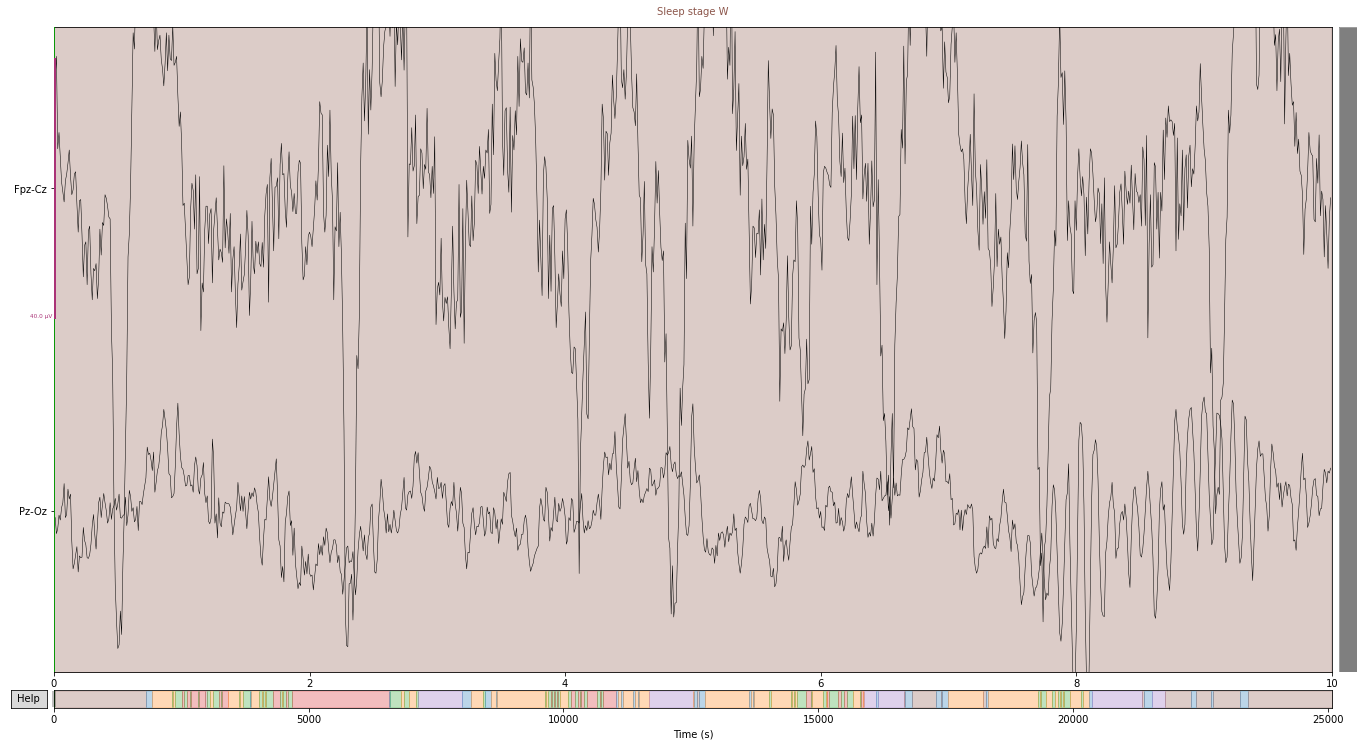

In [8]:
raws[0].plot();

## 2. Preprocessing raw data

Filter, then window

In [9]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)

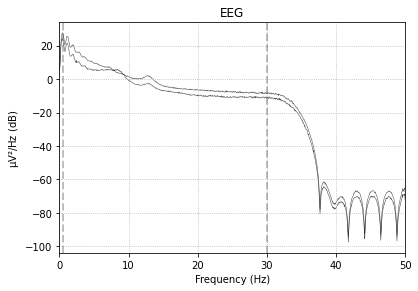

In [10]:
raws[0].plot_psd();

In [11]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract epochs from raw data.
    
    Parameters
    ----------
    ...
    
    Returns
    -------
    np.ndarray, np.ndarray
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, 
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1

In [12]:
import torch
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : 3d array, shape (n_epochs, n_channels, n_times)
        The epochs data.
    epochs_labels : array of int, shape (n_epochs,)
        The epochs labels.
    subj_nb ... XXX
    rec_nb ... XXX
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, 
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
    

def scale(X):
    """Standard scaling of data along the last dimention.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [13]:
# Apply windowing and move to pytorch dataset

all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], 
                              rec_nb=raw.info['subject_info']['rec_id'], transform=scale) 
                for raw in raws]
dataset = ConcatDataset(all_datasets)

## 3. Making train/valid/test splits

We will keep 10 subjects for the validation set, and 10 other subjects for the test set.

In [14]:
from sklearn.model_selection import LeavePGroupsOut


def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split torch dataset in train and test keeping n_groups out in test.
    
    Parameters
    ----------
    dataset : instance of ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.
        
    Returns
    -------
    ds_train : instance of Dataset
        The training data.
    ds_test : instance of Dataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])
        
    return train_ds, test_ds

In [15]:
torch.manual_seed(87)
np.random.seed(87)

In [16]:
train_ds, test_ds = train_test_split(dataset, 1, split_by='subj_nb')
train_ds, valid_ds = train_test_split(train_ds, 1, split_by='subj_nb')

In [17]:
len(train_ds), len(valid_ds), len(test_ds)

(1020, 1087, 836)

In [18]:
# Computing class weight

from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', np.unique(train_y), train_y)

/home/hubert/miniconda3/envs/dl-eeg-tutorial/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


## 4. Creating the neural network

In [19]:
from torch import nn


class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [20]:
sfreq = raws[0].info['sfreq']
n_channels = raws[0].info['nchan']

In [21]:
model = SleepStagerChambon2018(
    n_channels, sfreq, n_conv_chs=8, n_classes=5)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

## 5. Train and monitor network

In [23]:
from torch.utils.data import DataLoader

In [24]:
# Create dataloaders
train_batch_size = 64
valid_batch_size = 256
num_workers = 0

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [25]:
from sklearn.metrics import balanced_accuracy_score


def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()
        
        y_pred_all.append(torch.argmax(output, axis=1).numpy())
        y_true_all.append(batch_y.numpy())

        train_loss[idx_batch] = loss.item()
        
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    
    return np.mean(train_loss), perf
        

def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()
    
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()
            
            y_pred_all.append(torch.argmax(output, axis=1).numpy())
            y_true_all.append(batch_y.numpy())
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, 
          patience, device, metric=None):
    """Training function.
    
    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.
        
    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')

    for epoch in range(1, n_epochs + 1):
#         print(f'\nStarting epoch {epoch + 1} / {n_epochs}')
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_bal_acc': train_perf, 'valid_bal_acc': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [26]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

n_epochs = 10
patience = 5
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights))  #weight=!!!)

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, device)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
1 	 1.5764 	 1.4928 	 0.2571 	 0.3687
best val loss inf -> 1.4928
2 	 1.2842 	 1.1975 	 0.4382 	 0.4921
best val loss 1.4928 -> 1.1975
3 	 0.9786 	 0.9998 	 0.5718 	 0.5700
best val loss 1.1975 -> 0.9998
4 	 0.8208 	 1.1227 	 0.6643 	 0.4001
5 	 0.7704 	 0.9512 	 0.6750 	 0.4897
best val loss 0.9998 -> 0.9512
6 	 0.6983 	 0.8595 	 0.7156 	 0.6247
best val loss 0.9512 -> 0.8595
7 	 0.6407 	 0.7804 	 0.7202 	 0.6570
best val loss 0.8595 -> 0.7804
8 	 0.6043 	 0.7836 	 0.7491 	 0.6476
9 	 0.5573 	 0.8311 	 0.7634 	 0.5948
10 	 0.5180 	 0.7938 	 0.7776 	 0.6132


<AxesSubplot:xlabel='epoch'>

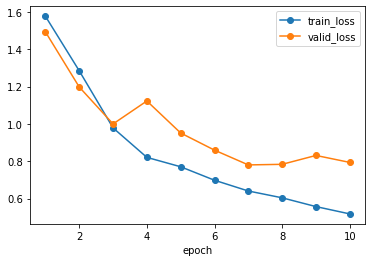

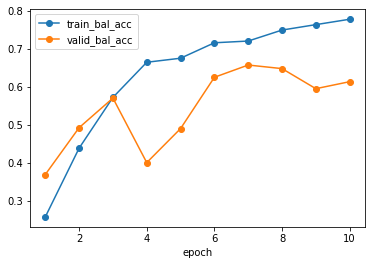

In [27]:
# Visualizing the learning curves

import pandas as pd

history_df = pd.DataFrame(history)
history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
history_df.plot(x='epoch', y=['train_bal_acc', 'valid_bal_acc'], marker='o')

In [28]:
# Compute test performance

best_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).numpy())
    y_true_all.append(batch_y.numpy())
    
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f'Test balanced accuracy: {test_bal_acc:0.3f}')

Test balanced accuracy: 0.655


## 6. Visualizing results

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [30]:
confusion_matrix(y_true, y_pred)

array([[ 80,  58,   9,   0,  36],
       [  0,  24,   3,   0,  31],
       [  0,   1, 198,   3,  48],
       [  0,   0,  61, 158,   1],
       [  0,  11,   0,   0, 114]])

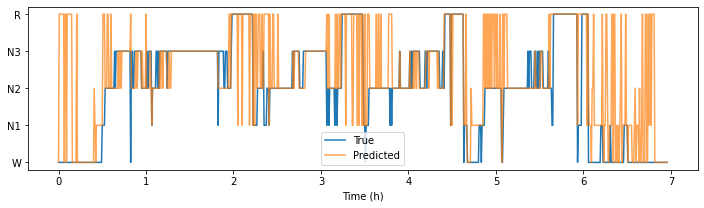

In [31]:
# Plot hypnogram for one recording
# XXX: Obtain predictions for single recording

t = np.arange(len(y_true)) * 30 / 3600

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, y_true, label='True')
ax.plot(t, y_pred, alpha=0.7, label='Predicted')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax.set_xlabel('Time (h)')
ax.legend()

XXX: Write section with a couple of hints of what to do to improve performance

Suggestions for potentially improving performance:
- Aggregating multiple predictions?
- Improving architecture
- Improving training, optimizer, etc.